# Introduction

This is one of I'm sure many notebooks here examining the MNIST dataset using PyTorch. Transfer learning is not used, rather a CNN with 3 convolutional layers, 4 hidden layers, and an output layer. This model was able to achieve 99.457%, although that does require a bit of a lucky run. 

My hope is that this notebook will help someone who is learning PyTorch, as I recently was. On that note, this notebook includes some PyTorch things like: a custom dataset class that inherits PyTorch's dataset class, transforms, putting data and the network on a GPU/CPU, various neurel network layers, a training loop, and an evaluation loop. Some images are also visualized using matplotlib and a simple confusion matrix is made. If you're new to PyTorch, hopefully you will find something useful in this notebook!

In [3]:
# Import Time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Quick function that gets how many out of 'preds' match 'labels'
# To be used much later
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [5]:
# Read in the train set and the test set
# In a kernel here on Kaggle, use the Workspace on the right-hand side to figure out the file path
train_set = pd.read_csv("./input/digit-recognizer/train.csv")
test_images = pd.read_csv("./input/digit-recognizer/test.csv")

# Split the train set so there is also a validation set
train_images, val_images, train_labels, val_labels = train_test_split(train_set.iloc[:, 1:], 
                                                                     train_set.iloc[:, 0], 
                                                                     test_size=0.2)

# Reset indices so the Dataset can find them with __getitem__ easily
train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

# Some Data Visualization

In [6]:
# Let's just display a number as a dataframe for fun 
# (I think it looks cool, plus it led to something else I tried, mentioned in the last section)
pd.set_option('display.max_columns', 28)
pd.DataFrame(train_images.iloc[3, :].to_numpy().reshape(28, 28))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,141,255,155,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,5,118,251,253,154,0,0,41,87,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,66,253,253,249,90,0,49,225,177,14,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,194,253,242,107,0,0,116,253,253,159,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,69,241,253,171,0,0,0,116,253,253,223,52,0,0,0,0,0,0,0


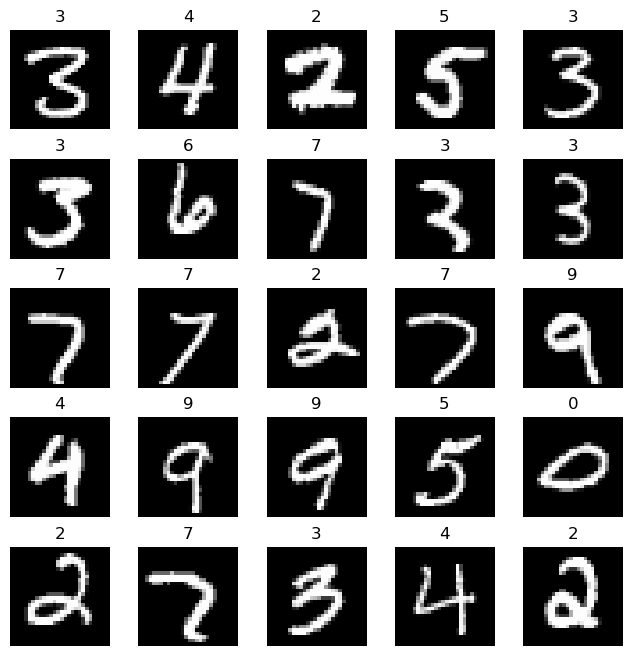

In [7]:
# Some quick data visualization
# (not a terribly exciting dataset)
# First 25 images in training set
# Note: label is above the image

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
fig.subplots_adjust(hspace=.3)
for i in range(5):
    for j in range(5):
        ax[i][j].axis('off')
        ax[i][j].imshow(train_images.iloc[[i+(j*5)], :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')
        ax[i][j].set_title(train_labels[i+(j*5)])

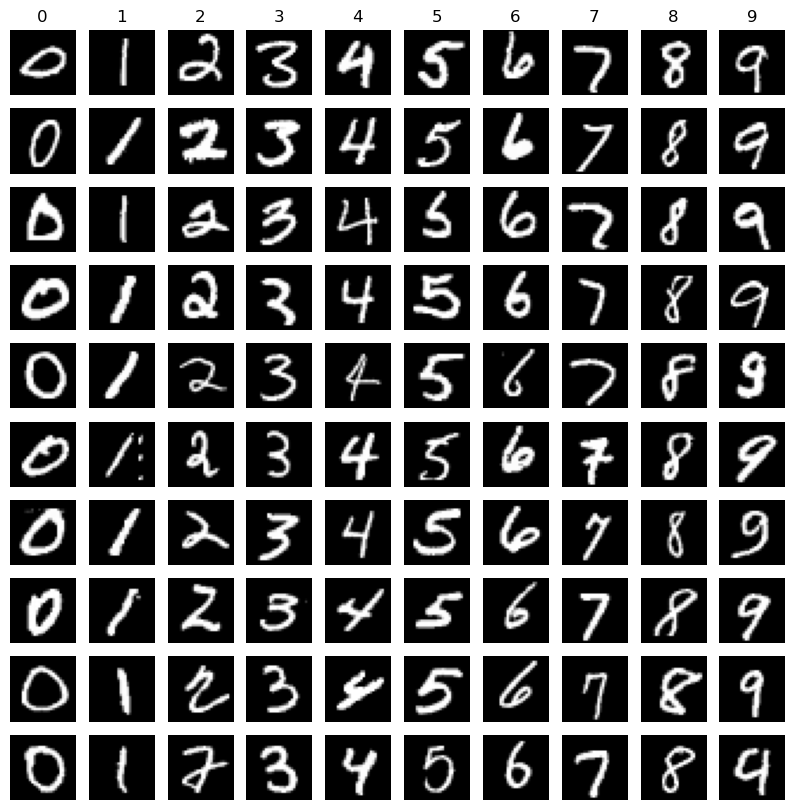

In [8]:
# Some more quick data visualization
# First 10 images of each class in the training set
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))

# I know these for loops look weird, but this way num_i is only computed once for each class
# Trust me the way I had this before was more normal, but this is more efficient
for i in range(10): # Column by column
    num_i = train_images[train_labels == i]
    ax[0][i].set_title(i)
    for j in range(10): # Row by row
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j, :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

# Set-Up

In [9]:
# Transformations
IMG_SIZE = 28 # size of images in MNIST
# Also the images only have one color channel
# So 3D size = (1, 28, 28)

# Transformations for the train
train_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.RandomCrop(IMG_SIZE), 
    transforms.ToTensor(), # divides by 255
  #  transforms.Normalize((0.5,), (0.5,))
]))

# Transformations for the validation & test sets
val_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor(), # divides by 255
   # transforms.Normalize((0.1307,), (0.3081,))
]))

# did worse w/o RandomCrop, if someone can explain why 
# (or if I'm crazy and should try it again) 
# I'd love to hear about it in the comments

In [10]:
# Custom class for the MNIST dataset from Kaggle
# Images come in a csv, not as actual images
# Training set is split before given to this class

class MNISTDataSet(torch.utils.data.Dataset):
    # images df, labels df, transforms
    # uses labels to determine if it needs to return X & y or just X in __getitem__
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
                    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = self.X.iloc[i, :] # gets the row
        # reshape the row into the image size 
        # (numpy arrays have the color channels dim last)
        data = np.array(data).astype(np.uint8).reshape(28, 28, 1) 
        
        # perform transforms if there are any
        if self.transforms:
            data = self.transforms(data)
        
        # if !test_set return the label as well, otherwise don't
        if self.y is not None: # train/val
            return (data, self.y[i])
        else: # test
            return data

In [11]:
# Get datasets using the custom MNIST Dataset for the train, val, and test images
train_set = MNISTDataSet(train_images, train_labels, train_trans)
val_set = MNISTDataSet(val_images, val_labels, val_trans)
test_set = MNISTDataSet(test_images, None, val_trans)

# Nice habit to get into
num_classes = 10 # 0-9

In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # image starts as (1, 28, 28)
        # Formula to compute size of image after conv/pool
        # (size-filter+2*padding / stride) + 1
        #                      inputs         # of filters    filter size    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2) # conv1
        self.conv1_bn = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2) # conv2
        self.conv2_bn = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=3, stride=1, padding=1) # conv3
        self.conv3_bn = nn.BatchNorm2d(num_features=128)
        
        self.fc1 = nn.Linear(in_features=128*6*6, out_features=1024) # linear 1
        self.fc1_bn = nn.BatchNorm1d(num_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512) # linear 2
        self.fc2_bn = nn.BatchNorm1d(num_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=256) # linear 3
        self.fc3_bn = nn.BatchNorm1d(num_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=64) # linear 4
        self.fc4_bn = nn.BatchNorm1d(num_features=64)
        self.out = nn.Linear(in_features=64, out_features=10) # output
    
    def forward(self, t):
        t = F.relu(self.conv1_bn(self.conv1(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=2) # (1, 14, 14)
        
        t = F.relu(self.conv2_bn(self.conv2(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=2) # (1, 7, 7)
        
        t = F.relu(self.conv3_bn(self.conv3(t)))
        t = F.max_pool2d(t, kernel_size=2, stride=1) # (1, 6, 6)
        
        t = F.relu(self.fc1_bn(self.fc1(t.reshape(-1, 128*6*6))))
        t = F.relu(self.fc2_bn(self.fc2(t)))
        t = F.relu(self.fc3_bn(self.fc3(t)))
        t = F.relu(self.fc4_bn(self.fc4(t)))
        t = self.out(t)
        
        return t

# Training Loop

In [13]:
lr = 0.001 # initial learning rate
batch_size = 100 # batch size
epochs = 10 # number of epochs to run

network = Network().to(device) # put the model on device (hopefully a GPU!)
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_set, batch_size=batch_size, shuffle=False)
optimizer = optim.Adam(network.parameters(), lr=lr)

import time

t1 = time.time()
for epoch in range(epochs):
    print("Epoch: ", epoch+1)
    epoch_loss = 0
    epoch_correct = 0
    network.train() # training mode
    
    # lessen the learning rate after 4 epochs (0,...,3)
    if epoch == 4:
        print(" decreasing lr")
        optimizer = optim.Adam(network.parameters(), lr=0.00001)
    
    if epoch == 10: # not currently used
        print(" decreasing lr again")
        optimizer = optim.Adam(network.parameters(), lr=0.0000000000001)
    
    for images, labels in train_dl:
        X, y = images.to(device), labels.to(device) # put X & y on device
        y_ = network(X) # get predictions
        
        optimizer.zero_grad() # zeros out the gradients
        loss = F.cross_entropy(y_, y) # computes the loss
        loss.backward() # computes the gradients
        optimizer.step() # updates weights
        
        epoch_loss += loss.item() * batch_size
        epoch_correct += get_num_correct(y_, y)
        
    # Evaluation with the validation set
    network.eval() # eval mode
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_dl:
            X, y = images.to(device), labels.to(device) # to device
            
            preds = network(X) # get predictions
            loss = F.cross_entropy(preds, y) # calculate the loss
            
            val_correct += get_num_correct(preds, y)
            val_loss = loss.item() * batch_size
    # Print the loss and accuracy for the validation set
    print(" Val Loss: ", val_loss)
    print(" Val Acc: ", (val_correct/len(val_images))*100)
t2 = time.time()
print(f"It took {t2-t1} seconds.")

Epoch:  1


KeyboardInterrupt: 

I believe network.train() and network.eval() are only needed if Dropout layers are used. Previous iterations had them. Also, I imagine it's another thing that's it's good to get in the habit of doing. 

# Network Evaluation

In [ ]:
# Use the validation set to make a confusion matrix
network.eval() # good habit I suppose
predictions = torch.LongTensor().to(device) # Tensor for all predictions

# Goes through the val set
# Don't care about the associated labels
for images, _ in val_dl:
    preds = network(images.to(device))
    predictions = torch.cat((predictions, preds.argmax(dim=1)), dim=0)

# Make the confusion matrix
cmt = torch.zeros(num_classes, num_classes, dtype=torch.int32)
for i in range(len(val_labels)):
    cmt[val_labels[i], predictions[i]] += 1


In [ ]:
# Doesn't look fancy but it works
# Actual class down the column (0-9), predicted class across the rows (0-9)
cmt

In [ ]:
# Time to get the network's predictions on the test set
# Put the test set in a DataLoader
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False)

network.eval() # Safety first
predictions = torch.LongTensor().to(device) # Tensor for all predictions

# Go through the test set, saving the predictions in... 'predictions'
for images in test_dl:
    preds = network(images.to(device))
    predictions = torch.cat((predictions, preds.argmax(dim=1)), dim=0)

In [ ]:
# Read in the sample submission
submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

In [ ]:
# Change the label column to our predictions 
# Have to make sure the predictions Tensor is on the cpu
submission['Label'] = predictions.cpu().numpy()

In [ ]:
# Write the dataframe to a new csv, not including the index
submission.to_csv("predictions.csv", index=False)

In [ ]:
# Save the model (if you really want for some reason)
# torch.save(network, "Model/mnist_network") 

In [ ]:
# 99.457% on MNIST test set on Kaggle (top 23%)
# (same on full training set w/ 15 epochs)
# 99.385% on a run through, depends on luck to get a bit higher (or maybe full training set, but also luck)

# Possible Future Notebook Improvements
 - Better-looking confusion matrix
 - Try to improve accuracy a bit more (maybe try SGD)
 - Save val_acc from each epoch, possibly end training early if using more epochs
 - Make blocks in CNN class so it's easier to quickly see the architecture

# Some Other Things I Tried:
 - Making each pixel in each image either 255 or 0 (before normalization) depending on how close to one of those two extremes it was 
        - Didn't help, didn't really hurt
 - Training the model on the whole training set
        - Usually didn't help/hurt, but had no way to see if it had been a good run or not without submitting it to Kaggle
 - I added a few transformations at first without really thinking, like ColorJitter
        - It definitely helped when I removed them
        - Think about if your transformations go with your dataset before adding them
 - Even though to me it seems like the RandomCrop transformation shouldn't really do anything in this case, it did worse when I removed it, so in it has since stayed